## Resource-Constrained Project Scheduling Problem with Sequence-Dependent Setup Time

This notebook demonstrates how to model and solve the Resource-Constrained Project Scheduling Problem with Sequence-Dependent Setup Times
using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API.
This problem extends the classical RCPSP (see [`rcpsp.ipynb`](https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb)).

### Problem Definiton

In the RCPSP with Sequence-Dependent Setup Times, we are given a finite set of tasks indexed by $i\in\{1,\dots,N\}$ and a finite set of **unary (disjunctive)** resources (machines) indexed by $k\in\{1,\dots,M\}$. Each task $i$ has a fixed duration $PT_i>0$. Every task must be processed on exactly one machine, and this assignment is part of the optimization: if task $i$ runs on machine $k$, its machine-specific interval is denoted $x_i^{(k)}$. For each machine $k$, a transition (setup) matrix $\mathrm{TM}_{k}=[S^{(k)}{ij}]$ specifies the setup time incurred if task $j$ immediately follows task $i$ on $k$. A set of precedence relations $P\subseteq\{1,\dots,N\}^2$ imposes ordering (i.e., $(i,j)\in P$ means $i$ must precede $j$). The goal is to minimize the makespan $C_{\max}$—the completion time of the last finishing task.

### CPLEX Formulation

$$
\begin{aligned}
\min\quad
& C_{\max} \;=\; \max_{i \in [1..N]} \mathrm{endOf}(x_i)
& & & \text{(1)} \\[6pt]
\text{s.t.}\quad
& \mathrm{endBeforeStart}(x_i, x_j)
& & \forall (i,j) \in P
& \text{(2)} \\[4pt]
& \mathrm{alternative}\!\bigl(x_i,\ \{\,x_i^{(k)} \mid k \in [1..M]\,\}\bigr)
& & \forall i \in [1..N]
& \text{(3)} \\[4pt]
& \mathrm{noOverlap}\!\bigl(\mathrm{seq}_k,\ \mathrm{TM}_k\bigr)
& & \forall k \in [1..M]
& \text{(4)} \\[6pt]
& \text{interval } x_i,\ \text{size} = PT_i
& & \forall i \in [1..N]
& \text{(5a)} \\
& \text{interval } x_i^{(k)}\ \text{(optional), size} = PT_i
& & \forall i \in [1..N],\; \forall k \in [1..M]
& \text{(5b)} \\
& \text{sequence } \mathrm{seq}_k\ \text{over }\{\,x_i^{(k)} \mid i \in [1..N]\,\}
& & \forall k \in [1..M]
& \text{(5c)}
\end{aligned}
$$

**Objective:**
- **(1)** The **makespan** $C_{\max}$ — the completion time of the last finishing task — is **minimized**.

**Modeling constraints:**
- **(2)** All precedence relations $(i,j)\in P$ are respected: task $i$ must finish before task $j$ starts.
- **(3)** Each task is executed on exactly one unary resource: for every $i$, we select one of the optional machine-specific copies $x_i^{(k)}$ and bind it to the global task interval $x_i$.
- **(4)** On each machine $k$, assigned tasks are processed without overlap, and sequence-dependent setup times apply according to the transition matrix $\mathrm{TM}_k$.

**Variables:**
- **(5a)** Interval variables $x_i$ (one per task) with fixed size $PT_i$, deciding task start/end times and contributing to $C_{\max}$.
- **(5b)** Optional machine-specific intervals $x_i^{(k)}$ (size $PT_i$) for each task–machine pair, enabling the choice of machine per task.
- **(5c)** For each machine $k$, a sequence variable $\mathrm{seq}_k$ that orders $\{x_i^{(k)}\}$ and enforces the non-overlap with transition matrix $\mathrm{TM}_k$.

#### Symbols and Notation

| Symbol / Function | Meaning | docplex.cp reference |
|---|---|---|
| $N$ | Number of tasks | — |
| $M$ | Number of unary (disjunctive) machines | — |
| $i$ | Task index ($i \in [1..N]$) | — |
| $k$ | Machine index ($k \in [1..M]$) | — |
| $PT_i$ | Processing time (duration) of task $i$ | — |
| $P$ | Precedence set $\subseteq [1..N]\times[1..N]$ | — |
| $x_i$ | Global interval var. for task $i$ (size $PT_i$) | [interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) |
| $x_i^{(k)}$ | Optional machine-specific copy of task $i$ on machine $k$ (size $PT_i$) | [interval_var (optional)](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) |
| $\mathrm{seq}_k$ | Sequence variable ordering $\{x_i^{(k)}\}$ on machine $k$ | [sequence_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.sequence_var) |
| $\mathrm{TM}_k$ | Transition (setup) matrix on machine $k$ with entries $S^{(k)}_{ij}$ | [transition_matrix](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.transition_matrix) |
| $\mathrm{alternative}(x_i,\{x_i^{(k)}\}_k)$ | Enforces machine choice: bind $x_i$ to exactly one $x_i^{(k)}$ | [alternative](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) |
| $\mathrm{endBeforeStart}(x_i,x_j)$ | Enforces precedence $i \rightarrow j$ | [end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) |
| $\mathrm{noOverlap}(\mathrm{seq}_k,\mathrm{TM}_k)$ | Non-overlap on machine $k$ with sequence-dependent setups | [no_overlap](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.no_overlap) |
| $\mathrm{endOf}(x)$ | End time of interval $x$ | [end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $C_{\max}$ | Makespan (completion time of the last finishing task) | — |
| $\min\ C_{\max}$ | Makespan minimization objective | [minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) |


### CPLEX Implementation

#### Imports

In [1]:
from docplex.cp.model import *
import docplex.cp.utils_visu as visu

#### Reading the data file

In [2]:
filename = "../data/rcpspst/rcpspst_default.data"

# Line 1: N M                      -> number of tasks, number of unary machines
# Next N lines (tasks 1..N):
#   PT_i  E_i  m1 ... mE_i         -> duration; #eligible machines; eligible machine ids (1..M)
# Next line: L                     -> number of precedence arcs
# Next L lines:
#   i j                            -> precedence (task i must precede task j), 1-based
# Then for each machine k = 1..M:
#   TM k                           -> tag starting the setup matrix for machine k (1-based)
#   N lines of N integers          -> S_ij^(k): setup time if j follows i on machine k

with open(filename, "r") as f:
    ri = lambda: list(map(int, f.readline().split()))
    N, M = ri()
    PT, eligible = [], []
    for _ in range(N):
        row = ri()
        PT.append(row[0])
        e = row[1]
        eligible.append([m - 1 for m in row[2:2 + e]])
    P = [(i - 1, j - 1) for i, j in (map(int, f.readline().split()) for _ in range(int(f.readline())))]
    TM = []
    for _ in range(M):
        assert f.readline().split()[0] == "TM"
        TM.append([ri() for _ in range(N)])

#### Create model and variables

In [ ]:
mdl = CpoModel()

# (5a) Global intervals x_i
x = [interval_var(name=f"T{i+1}", size=PT[i]) for i in range(N)]

# (5b) Optional machine-specific copies x_i^(k), use None for ineligible machine-task pairs
xk = [[interval_var(name=f"T{i+1}_M{k+1}", size=PT[i], optional=True) if k in eligible[i] else None for k in range(M)] for i in range(N)]

# (5c) One sequence per machine over its present optional intervals
seq = [sequence_var([xk[i][k] for i in range(N) if xk[i][k] is not None], name=f"SEQ_M{k+1}") for k in range(M)]

# Transition matrices with the setup time
TM_cp = [transition_matrix(TM[k]) for k in range(M)]

#### Add constraints and define objective

In [4]:
# (2) Precedence arcs
mdl.add([end_before_start(x[i], x[j]) for i, j in P])

# (3) alternative: select exactly one machine for each task (among eligible)
mdl.add([alternative(x[i], [xk[i][k] for k in eligible[i]]) for i in range(N)])

# (4) Disjunctive + sequence-dependent setups on each machine
mdl.add([mdl.no_overlap(seq[k], TM_cp[k]) for k in range(M)])

# (1) Objective: minimize max endOf(x_i)
mdl.add(mdl.minimize(mdl.max(end_of(x[i]) for i in range(N))))

#### Solve the model

In [5]:
print('Solving model...')
res = mdl.solve(FailLimit=100000,TimeLimit=10)
print('Solution: ')
res.print_solution()

Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.2.0 --
 ! Minimization problem - 15 variables, 11 constraints
 ! FailLimit            = 100000
 ! TimeLimit            = 10
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 14.6 (before), 14.6 (after)
 !  . Memory usage      : 441.6 kB (before), 441.6 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         15                 -
 + New bound is 13
 *            19       15  0.01s        1      (gap is 31.58%)
 *            15       30  0.01s        1      (gap is 13.33%)
              15       31          6    1   F        -
 + New bound is 15 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! B

#### Visualisation

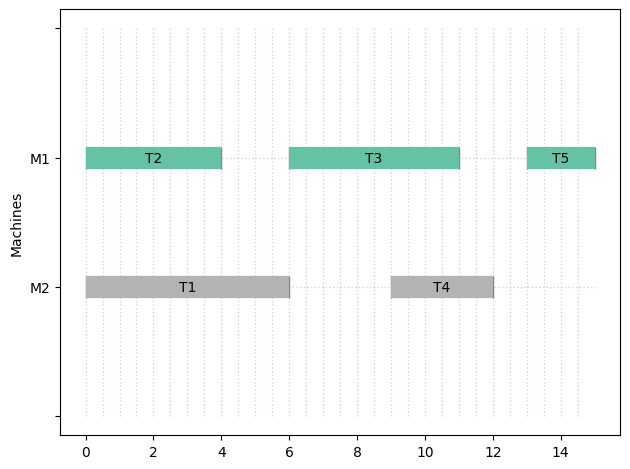

In [6]:
if res and visu.is_visu_enabled():
    visu.panel("Machines")
    for k in range(M):
        intervals = []
        for i in range(N):
            if xk[i][k] is not None:
                itv = res.get_var_solution(xk[i][k])
                if itv and itv.is_present():
                    intervals.append((itv, k, f"T{i+1}"))
        visu.sequence(name=f"M{k+1}", intervals=intervals)
    visu.show()


### Aditional Resources

- **IBM Modeling sequence-dependent setup times**
  - https://www.ibm.com/docs/en/icos/22.1.1?topic=models-modeling-sequence-dependent-setup-times